# 2nd milestone

In [1]:
from keras import models
from keras import layers
from keras import optimizers
from keras.layers import Dense, Activation, BatchNormalization, Conv2D, BatchNormalization, MaxPooling2D, UpSampling2D, Flatten
import numpy as np
import scipy as sp
from skimage import color
import warnings
import keras
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

O:\ProgrammingSoftwares\anaconda3\envs\tensor-cpu\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### Starting info

I started from this paper: <b>Colorful image colorization - Richard Zhang, Phillip Isola, Alexei A. Efros</b>
https://arxiv.org/pdf/1603.08511.pdf

In short they found out, that image colorization problem considered as a multinomial classification problem give better results than the other older solutions for this problem. Because of that, they first turned the RGB pixels into LAB colorspace. In this colorspace, the colorisation problem can be interpreted as input = L, output = a,b.  
First they created an RGB distribution ->  RGB(a,b|L = 50)
![RGB distribution](img_for_description/rgb_distribution.png)  
  
After that they discretize the values, with this method they got 313 class which are different pixels. This discretized list is saved to numpy pts_hull_file, it is a 2 dimensional with shape of (313,2) where the axis 1 refers to a,b pairs.
I'm using up this array, in my function D which map all of the pixel=(L1,a1,b1) to a one hot encoded vector with shape (313,).   This D decide where this pixel belong from the discretized values, after that encode to one hot vector.


https://en.wikipedia.org/wiki/CIELAB_color_space  
  
### Comments for the below code

    - Image folder is where all of you data is, you have to change to your filepath, where is your samples.

    - Pts_hull_file is the discrete class array, which are created from RGB-LAB distribution. You don't have to recreate, it is in the repo/samples folder.
    
    - ImageLoader class will hold the prepared data for the training and evaluation.
    - img_loader.separate_small_data(valid_split,test_split) prepares the data to train.


In [2]:
# Import own .py files
import data_collector
import image_loader
import nnetwork
from utility_methods import save_plots
from importlib import reload  # Python 3.4+ only.
nnetwork = reload(nnetwork)
import gc


def teszt():
    gc.collect()
    image_folder = 'O:/ProgrammingSoftwares/anaconda_projects/dp_nagyhazi/samples/images/'
    pts_hull_file = 'O:/ProgrammingSoftwares/anaconda_projects/dp_nagyhazi/samples/pts_in_hull.npy'

    img_loader = image_loader.ImageLoader(image_folder, pt_in_hull_folder = pts_hull_file)

    # Separate_small_data(validation_rate, test_rate)
    img_loader.separate_small_data(0.1,0.1)
    return img_loader

O:\ProgrammingSoftwares\anaconda3\envs\tensor-cpu\lib\site-packages\skimage\viewer\utils\core.py:10: UserWarning: Recommended matplotlib backend is `Agg` for full skimage.viewer functionality.
  warn("Recommended matplotlib backend is `Agg` for full "
O:\ProgrammingSoftwares\anaconda_projects\dp_nagyhazi\src\utility_methods.py:3: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "O:\ProgrammingSoftwares\anaconda3\envs\tensor-cpu\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "O:\ProgrammingSoftwares\anaconda3\envs\tensor-cpu\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "O:\ProgrammingSoftwares\anaconda3\envs\tensor-cpu\lib\site-packages\ipykernel\

In [3]:
#%load_ext memory_profiler
img_loader = teszt()

Length of image list:  27


O:\ProgrammingSoftwares\anaconda3\envs\tensor-cpu\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


Gigabyte of dataset:  0.03028106689453125
Gigabyte of y_dataset:  0.0018925666809082031


O:\ProgrammingSoftwares\anaconda3\envs\tensor-cpu\lib\site-packages\sklearn\preprocessing\_encoders.py:363: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


### Info for the below code.

I've created the first model, which built up from a vgg16 keras model and after it batch norm and some convolution layers. These last convolution layers are responsible to convert the collected features into an a,b discretized distribution. Becuase of multinomial classification i thought the categorical crossentropy will be the best for me.

In [103]:
nnetwork = reload(nnetwork)
model = nnetwork.create_vgg_model(1,8)
model.compile('adam', loss = 'categorical_crossentropy',
              metrics=['accuracy', keras.metrics.categorical_accuracy])

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_30 (InputLayer)        (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_____________________________

In [75]:
def custom_objective(y_true, y_pred):
    '''Just another crossentropy'''
    print(y_true)
    print(type(y_true))
    return 1

In [21]:
patience=50
early_stopping=EarlyStopping(monitor='val_acc',patience=patience, verbose=1)
checkpointer=ModelCheckpoint(filepath='weights.hdf5', monitor='val_acc', save_best_only=True, verbose=1)

In [10]:
history = model.fit(x=img_loader.X_train,
                    y=img_loader.Y_train,
                    batch_size=16,
                    epochs=30,
                    validation_data=(img_loader.X_valid,img_loader.Y_valid),
                   callbacks=[checkpointer, early_stopping])

Train on 19 samples, validate on 2 samples
Epoch 1/30
19/19 [==============================] - 18s 943ms/step - loss: 5.8294 - acc: 0.0218 - categorical_accuracy: 0.0218 - val_loss: 2.9713 - val_acc: 0.4960 - val_categorical_accuracy: 0.4960

Epoch 00001: val_acc improved from -inf to 0.49601, saving model to weights.hdf5
Epoch 2/30
19/19 [==============================] - 17s 891ms/step - loss: 3.7136 - acc: 0.3767 - categorical_accuracy: 0.3767 - val_loss: 2.2060 - val_acc: 0.4960 - val_categorical_accuracy: 0.4960

Epoch 00002: val_acc did not improve from 0.49601
Epoch 3/30
19/19 [==============================] - 16s 867ms/step - loss: 2.9820 - acc: 0.3784 - categorical_accuracy: 0.3784 - val_loss: 2.3980 - val_acc: 0.1298 - val_categorical_accuracy: 0.1298

Epoch 00003: val_acc did not improve from 0.49601
Epoch 4/30
19/19 [==============================] - 16s 857ms/step - loss: 2.9390 - acc: 0.2890 - categorical_accuracy: 0.2890 - val_loss: 2.2196 - val_acc: 0.1317 - val_catego

In [11]:
score = model.evaluate(img_loader.X_test, img_loader.Y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

3/3 [==============================] - 2s 564ms/step
Test loss: 2.9197821617126465
Test accuracy: 0.2089710831642151


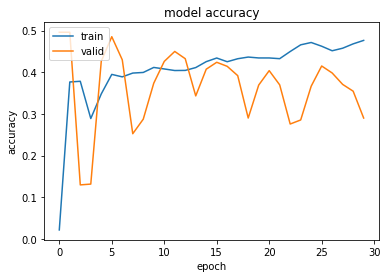

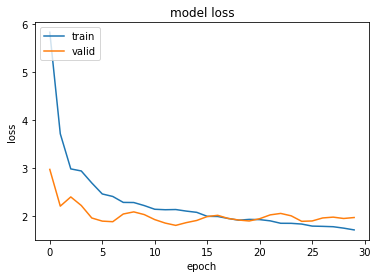

In [12]:
save_plots(history)

Changing the <b>idx</b> you can try out what did the network do.

(224, 224, 3)
(1, 56, 56, 2)
(224, 224, 3)
(1, 56, 56, 2)


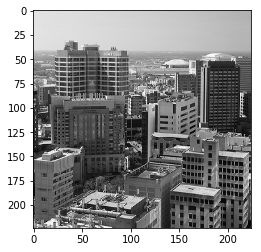

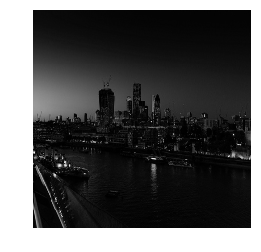

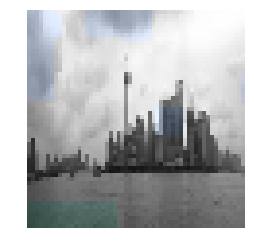

In [31]:
from matplotlib.pyplot import imshow
from skimage import color
import matplotlib.pyplot as plt
%matplotlib inline



for idx in range(len(img_loader.X_valid)):
    rgb_im = img_loader.X_valid[idx]
    plt.imshow(rgb_im)
    print(rgb_im.shape)
    plt.figure()
    y_real = model.predict(img_loader.X_train[idx].reshape((1,224,224,3)))
    y_real = np.apply_along_axis(lambda x: img_loader.pts_in_hull[np.argmax(x)], axis=3, arr = y_real)
    img_loader.pts_in_hull # létező színosztályok
    print(y_real.shape)
    lab_im = np.concatenate([img_loader.y_dataset[np.newaxis,idx,:,:,0, np.newaxis],y_real ], axis=3)
    rgb_im = color.lab2rgb(lab_im[0])
    plt.imshow(rgb_im)
    plt.axis('off')
    #plt.savefig(root_pictures + 'test_img'+str(idx)+'.png', bbox_inches='tight')

In [20]:
img_loader.y_dataset.shape

(24, 56, 56, 3)

In [44]:
test_weights = 'O:/ProgrammingSoftwares/anaconda_projects/dp_nagyhazi/tests/20181126/weights.hdf5'
root_pictures = 'O:/ProgrammingSoftwares/anaconda_projects/dp_nagyhazi/tests/20181126/test_pics/'
#model = keras.models.load_model(test_weights)

In [105]:
from keras.callbacks import EarlyStopping, LambdaCallback,ModelCheckpoint, CSVLogger
from utility_methods import collect_and_separate_labels, collect_labels,save_plots, save_plots_callback
import streaming_data
streaming_data = reload(streaming_data)
image_folder = 'O:/ProgrammingSoftwares/anaconda_projects/dp_nagyhazi/samples/images/'
patience=15
early_stopping=EarlyStopping(monitor='val_acc',patience=patience, verbose=1)
checkpointer=ModelCheckpoint(filepath='weights.hdf5',monitor='val_acc', save_best_only=True, verbose=1)
csv_logger = CSVLogger('training.log', append=True)
traain = streaming_data.StreamingDataGenerator(image_folder,batch_size=16)


Length of image list:  27


In [ ]:
import warnings

warnings.filterwarnings("ignore", category=UserWarning)
history = model.fit_generator(generator=traain,
                    validation_data=traain,
                    epochs=30,
                    callbacks=[csv_logger,checkpointer, early_stopping])

Epoch 1/30
1/1 [==============================] - 43s 43s/step - loss: 3.0593 - acc: 0.3428 - categorical_accuracy: 0.3428 - val_loss: 2.8436 - val_acc: 0.3509 - val_categorical_accuracy: 0.3509

Epoch 00001: val_acc did not improve from 0.35605
Epoch 2/30
1/1 [==============================] - 38s 38s/step - loss: 2.8436 - acc: 0.3509 - categorical_accuracy: 0.3509 - val_loss: 2.7643 - val_acc: 0.3714 - val_categorical_accuracy: 0.3714

Epoch 00002: val_acc improved from 0.35605 to 0.37139, saving model to weights.hdf5
Epoch 3/30
1/1 [==============================] - 38s 38s/step - loss: 2.7643 - acc: 0.3714 - categorical_accuracy: 0.3714 - val_loss: 2.5750 - val_acc: 0.3810 - val_categorical_accuracy: 0.3810

Epoch 00003: val_acc improved from 0.37139 to 0.38098, saving model to weights.hdf5
Epoch 4/30
1/1 [==============================] - 39s 39s/step - loss: 2.5750 - acc: 0.3810 - categorical_accuracy: 0.3810 - val_loss: 2.4412 - val_acc: 0.3858 - val_categorical_accuracy: 0.3858

(375, 500, 3)
(176, 500, 3)
(332, 500, 3)
(333, 500, 3)
(500, 332, 3)
(375, 500, 3)
(333, 500, 3)
(381, 500, 3)
(333, 500, 3)
(500, 375, 3)
(333, 500, 3)
(375, 500, 3)
(375, 500, 3)
(500, 375, 3)
(333, 500, 3)
(375, 500, 3)
(375, 500, 3)
(214, 500, 3)
(165, 500, 3)
(333, 500, 3)
(334, 500, 3)
(334, 500, 3)
(181, 500, 3)
(323, 500, 3)
(423, 564, 3)
(506, 742, 3)
(1144, 1920)
Length of image list:  27
XMAX 254.96705596301058


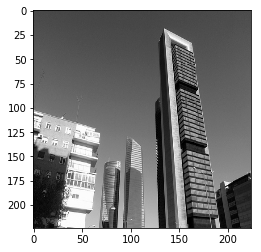

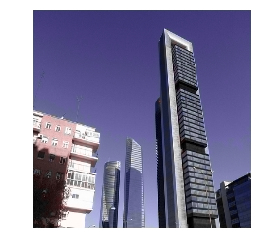

XMAX 254.96898804209187


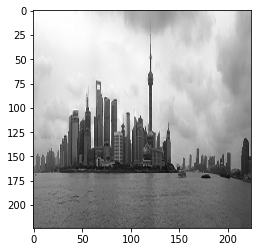

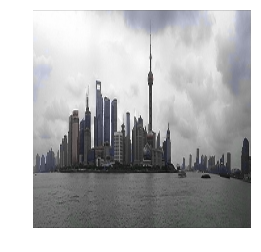

XMAX 254.69465326052295


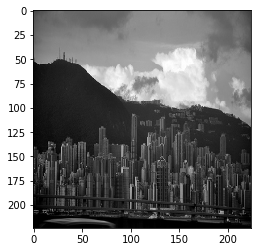

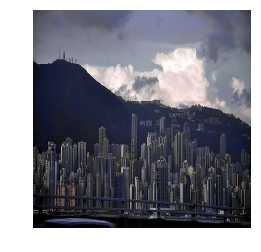

XMAX 245.2131930943076


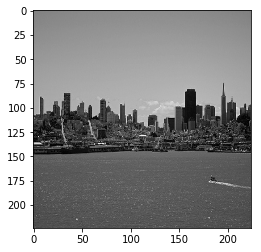

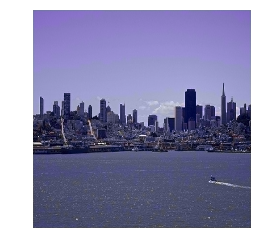

XMAX 250.92511895727083


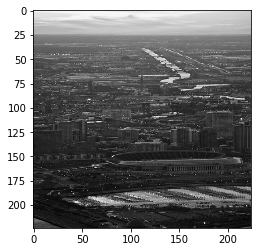

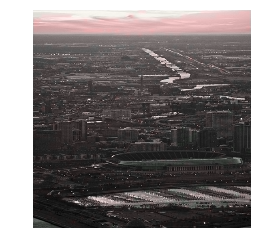

XMAX 254.60430795400143


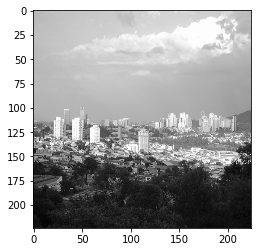

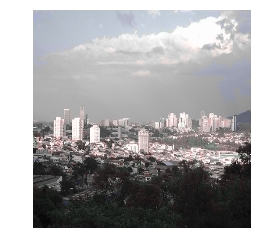

XMAX 254.04293728475764


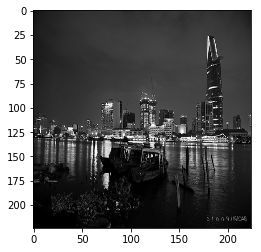

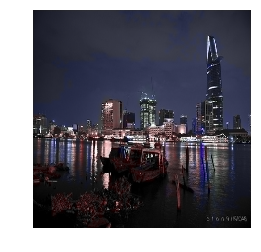

XMAX 235.88004027622748


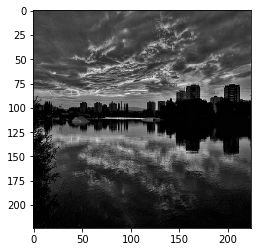

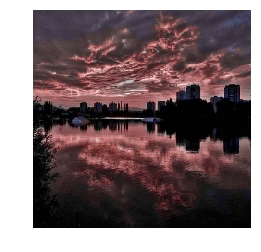

XMAX 254.94155673828107


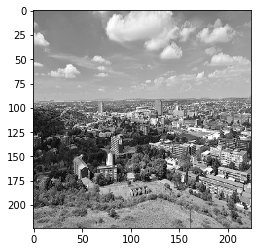

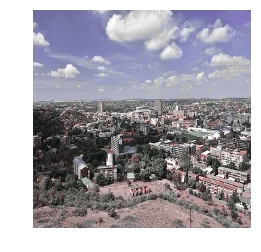

XMAX 192.84483541334578


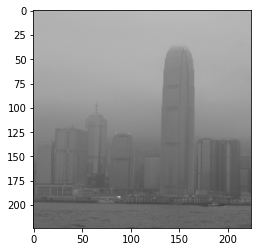

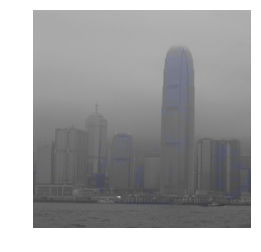

XMAX 234.22499283521992


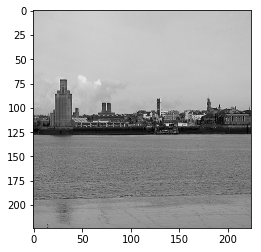

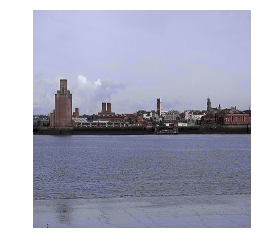

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


XMAX 255.00000000000003


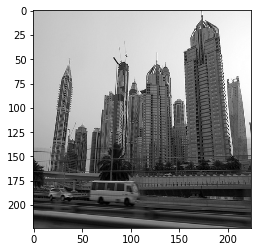

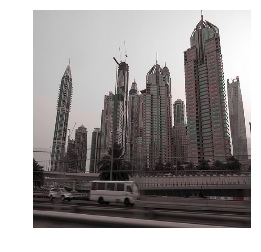

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


XMAX 255.00000000000003


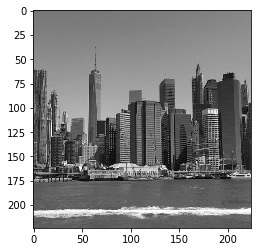

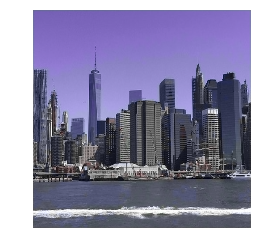

XMAX 254.50800866549721


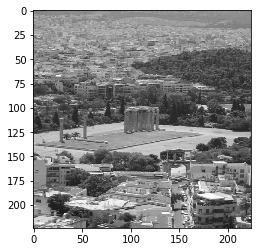

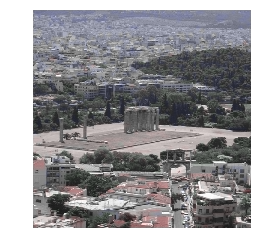

XMAX 183.11160714285722


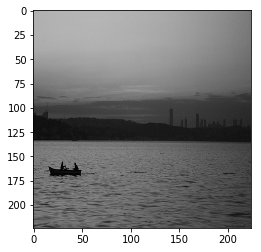

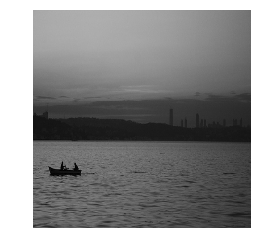

XMAX 191.38044560546845


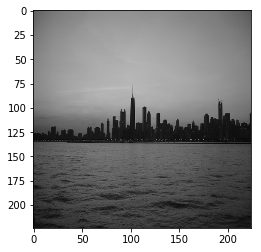

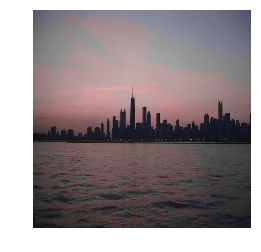

XMAX 254.48791204360737


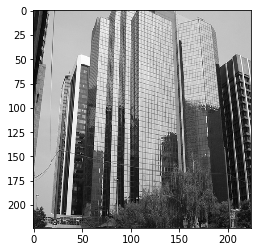

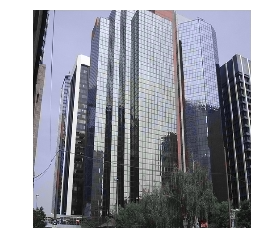

XMAX 254.12043535156252


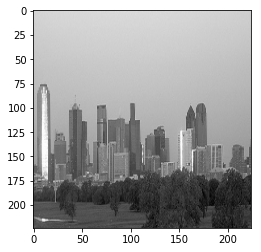

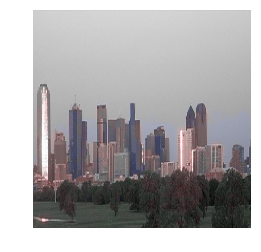

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


XMAX 255.00000000000003


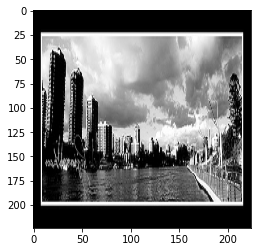

KeyboardInterrupt: 

In [102]:
from matplotlib.pyplot import imshow
from skimage import color
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from skimage import transform, io, color

from importlib import reload  # Python 3.4+ only.
import streaming_data
streaming_data = reload(streaming_data)

watcher = streaming_data.StreamingDataGenerator(image_folder,batch_size=1)

for idx in range(len(watcher)):
    X,Y = watcher[idx]
    print('XMAX', np.max(X))
    plt.imshow(watcher.gray_img[0]/255)
    plt.show()
    
    rgb_img = conc_pred(model, X, watcher,Y)
    plt.imshow(rgb_img)
    plt.axis('off')
    plt.savefig(root_pictures + 'test_img'+str(idx)+'.png', bbox_inches='tight')
    plt.show()
    

In [42]:
def conc_pred(model, X, watcher, Y = None):
    y_real = model.predict(X)
    if (Y is not None):
        y_real = Y
    # Choose the a-b colors from the color classes.
    y_real = np.apply_along_axis(lambda x: watcher.pts_in_hull[np.argmax(x)], axis=3, arr = y_real)[0]
    lightness_3 = transform.resize( watcher.gray_img[0] , (56,56), preserve_range=True)
    
    lab_im = np.concatenate([lightness_3[:,:,0,np.newaxis]/255, y_real[:,:,0,np.newaxis],y_real[:,:,1,np.newaxis]], axis = 2)

    
    rgb_img = color.lab2rgb(lab_im)
    rgb_img = transform.resize( rgb_img , (224,224), preserve_range=False)
    lab_im = color.rgb2lab(rgb_img)
    lab_im = np.concatenate([watcher.gray_img[0,:,:,0,np.newaxis]/255*100, lab_im[:,:,1,np.newaxis],lab_im[:,:,2,np.newaxis]], axis = 2)

    rgb_img = color.lab2rgb(lab_im)
    
    return rgb_img